**Random Over-Sampling With imblearn and LIME Interpretability for E-commerce Fraud Detection**</br>
**Preprocessing**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

sns.set_style('white')



In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [22]:
%%time
train_id = pd.read_csv('train_identity.csv')
train_tran = pd.read_csv('train_transaction.csv')


CPU times: user 17.2 s, sys: 11.7 s, total: 28.9 s
Wall time: 31.4 s


In [4]:
print(train_id.shape)
print(train_tran.shape)

(144233, 41)
(590540, 394)


In [23]:
merged_data = pd.merge(train_tran, train_id, on='TransactionID', how='left')


In [6]:
merged_data

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
train_sample = merged_data.sample(frac=0.75)

In [8]:

train_sample.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
280674,3267674,0,6828138,19.697,C,4461,375.0,185.0,mastercard,224.0,...,chrome 63.0,NaN,NaN,NaN,F,F,T,F,desktop,Windows
82081,3069081,0,1773979,20.871,C,1976,545.0,185.0,visa,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47697,3034697,0,1127301,49.000,W,7676,512.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15997,3002997,0,430336,30.000,W,12970,NaN,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142284,3129284,0,2925984,554.000,W,12501,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
train_sample.shape

(442905, 434)

In [25]:
train_sample = reduce_mem_usage(train_sample) # Reduce memory usage

Memory usage of dataframe is 1469.91 MB
Memory usage after optimization is: 397.14 MB
Decreased by 73.0%


In [11]:
# Calculate the percentage of fraudulent transactions
fraud_perc = train_sample['isFraud'].sum() / len(train_sample) * 100
fraud_perc 

3.5102335715333983

<AxesSubplot:>

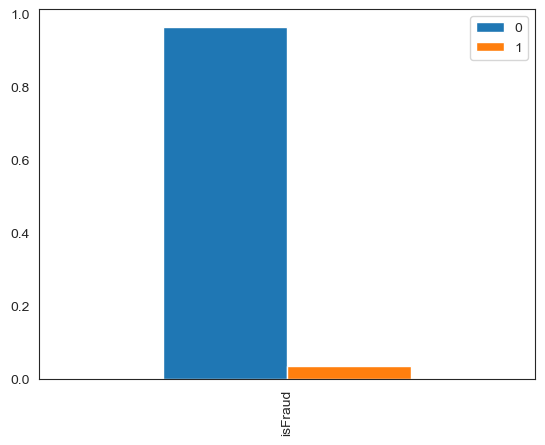

In [12]:
# Calculate and transpose the value counts
fraud_count = train_sample['isFraud'].value_counts(normalize=True).to_frame().T

# Plot the transposed value counts
fraud_count.plot.bar()


In [13]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442905 entries, 280674 to 30221
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float16(354), float32(45), int16(1), int32(2), int8(1)
memory usage: 397.1 MB


In [26]:
START_DATE = '2021-11-30'# Assume a start date
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")

train_sample['Date'] = train_sample['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
train_sample['_weekday'] = train_sample['Date'].dt.dayofweek
train_sample['_hour'] = train_sample['Date'].dt.hour
train_sample['_day'] = train_sample['Date'].dt.day


In [50]:
vcols = [col for col in train_sample.columns if col.startswith('V')]
len(vcols)

56

In [27]:
# Grouping numerical columns
nid_cols = [col for col in train_sample.columns if col.startswith('id_')]
ccols = [col for col in train_sample.columns if col.startswith('C')]
dcols = [col for col in train_sample.columns if col.startswith('D')]
dcols = [dcols[i] for i in range(0,15)]
mcols = [col for col in train_sample.columns if col.startswith('M')]
vcols = [col for col in train_sample.columns if col.startswith('V')]


In [28]:
cut_off_parameter = 0.75

In [29]:
# Drop highly correlated features from 'C' columns

corr_matrix = train_sample[['isFraud'] + ccols].corr(method='spearman').abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > cut_off_parameter)]
train_sample = train_sample.drop(to_drop, axis=1)


In [14]:
# to_drop

['C8', 'C10', 'C11', 'C12', 'C14']

In [21]:
corr_matrix

,isFraud,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
isFraud,1.000000,0.077897,0.088768,0.011507,0.161618,0.105903,0.051176,0.168120,0.155393,0.093414,0.152932,0.078632,0.157210,0.076783,0.064701
C1,0.077897,1.000000,0.730841,0.036249,0.156794,0.455825,0.632045,0.064476,0.165582,0.554561,0.154936,0.737155,0.008762,0.690891,0.871930
C2,0.088768,0.730841,1.000000,0.043294,0.053843,0.396692,0.637713,0.091348,0.065263,0.480322,0.056125,0.754968,0.124310,0.650769,0.660735
C3,0.011507,0.036249,0.043294,1.000000,0.085032,0.047792,0.104349,0.023035,0.105856,0.080497,0.105170,0.033278,0.029144,0.042373,0.033943
C4,0.161618,0.156794,0.053843,0.085032,1.000000,0.409309,0.159610,0.651310,0.915228,0.689405,0.890675,0.071135,0.477592,0.349079,0.249953
C5,0.105903,0.455825,0.396692,0.047792,0.409309,1.000000,0.405287,0.265929,0.416467,0.556747,0.405757,0.463483,0.276255,0.491158,0.503660
C6,0.051176,0.632045,0.637713,0.104349,0.159610,0.405287,1.000000,0.021608,0.178965,0.524490,0.172552,0.658399,0.024465,0.561447,0.596403
C7,0.168120,0.064476,0.091348,0.023035,0.651310,0.265929,0.021608,1.000000,0.582721,0.447908,0.545067,0.016967,0.804227,0.209601,0.141446
C8,0.155393,0.165582,0.065263,0.105856,0.915228,0.416467,0.178965,0.582721,1.000000,0.701461,0.970558,0.083907,0.419919,0.357371,0.256776
C9,0.093414,0.554561,0.480322,0.080497,0.689405,0.556747,0.524490,0.447908,0.701461,1.000000,0.683422,0.523092,0.281053,0.676869,0.601660


In [30]:
# Drop highly correlated features from 'D' columns
corr_matrix = train_sample[['isFraud'] + dcols].corr(method='spearman').abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > cut_off_parameter)]
train_sample = train_sample.drop(to_drop, axis=1)


In [31]:
# Drop highly correlated features from 'M' columns
corr_matrix = train_sample[['isFraud'] + mcols].corr(method='spearman').abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > cut_off_parameter)]
train_sample = train_sample.drop(to_drop, axis=1)


In [32]:
# Drop highly correlated features from 'V' columns
corr_matrix = train_sample[['isFraud'] + vcols].corr(method='spearman').abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > cut_off_parameter)]
train_sample = train_sample.drop(to_drop, axis=1)


In [51]:
# len(vcols)

56

In [52]:
# len(to_drop)

256

In [33]:
# Drop columns having more than 75 % of null values
train_sample = train_sample[train_sample.columns[train_sample.isnull().mean() < 0.75]]

In [34]:
# Get all numerical and categorical columns

num_cols = train_sample.select_dtypes(exclude=['object', 'category']).columns
cat_cols = train_sample.select_dtypes(include=['object', 'category']).columns

# Fill missing values in numerical columns with mean value

train_sample[num_cols] = train_sample[num_cols].apply(pd.to_numeric, errors='coerce').astype(float)
train_sample[num_cols] = train_sample[num_cols].fillna(train_sample[num_cols].mean())

# Fill missing values in categorical columns with mode

train_sample[cat_cols] = train_sample[cat_cols].fillna(train_sample[cat_cols].mode().iloc[0])





In [42]:
# Label Encoding the categorical columns
from sklearn.preprocessing import LabelEncoder

for f in train_sample.columns:
    if train_sample[f].dtype=='object' or train_sample[f].dtype.name=='category': 
        lbl = LabelEncoder()
        lbl.fit(list(train_sample[f].values))
        train_sample[f] = lbl.transform(list(train_sample[f].values))


#### Apply Sampling technique - Random Over-Sampling With imblearn

One way to fight imbalanced data is to generate new samples in the minority classes. The most naive strategy is to generate new samples by random sampling with the replacement of the currently available samples. The RandomOverSampler offers such a scheme.

In [53]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
# Separate input features and output feature
X = train_sample.drop(columns=['isFraud', 'TransactionID', 'TransactionDT', 'Date'])
Y = train_sample.isFraud

# Initialize Random Over-Sampler
ros = RandomOverSampler(random_state=25)

# Fit and Resample Data
X_ros, Y_ros = ros.fit_resample(X, Y)

print('Original dataset shape:', Counter(Y))
print('Resample dataset shape:', Counter(Y_ros))



Original dataset shape: Counter({0.0: 427453, 1.0: 15452})
Resample dataset shape: Counter({1.0: 427453, 0.0: 427453})


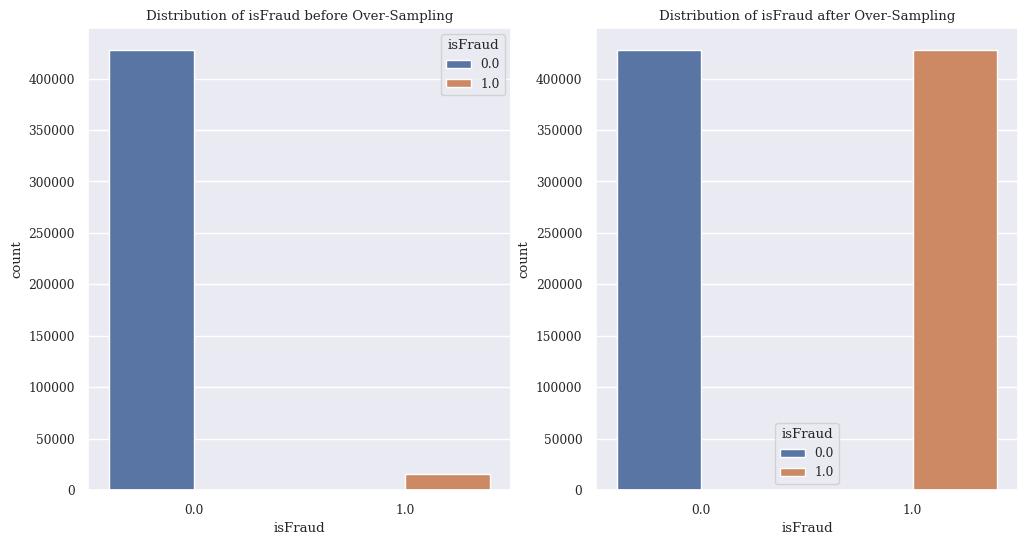

In [55]:

# Set up subplots
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

# Plot the distribution of isFraud before Over-Sampling
axs[0].set_title('Distribution of isFraud before Over-Sampling')
sns.countplot(x=Y, hue=Y, ax=axs[0])

# Plot the distribution of isFraud after Over-Sampling
axs[1].set_title('Distribution of isFraud after Over-Sampling')
sns.countplot(x=Y_ros, hue=Y_ros, ax=axs[1])

# Show the plot
plt.show()
